In [1]:
import sys
sys.path.append('../src/')

In [2]:
%load_ext autoreload
%autoreload 2
from inspector_cls import load_model
from patch import patch_suppress_enhance

In [3]:
import os
import seaborn as sb
import pickle
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

from matplotlib import pyplot as plt
import numpy as np

from tqdm import tqdm

from val_utils import get_top_neurons

In [4]:
import seaborn as sb

In [5]:
import umap

In [6]:
def get_cls_embeddings(data, inspector):
    embeddings = []
    for text in tqdm(data.text.tolist()):
        encoded_input = insp.tokenizer(text, return_tensors='pt', truncation=True, max_length=512)
        encoded_input.to(insp.device)
        output = insp.model(**encoded_input)
        cls_embedding = output.hidden_states[-1][0, 0, :].detach().cpu().numpy()
        embeddings.append(cls_embedding)
    return np.array(embeddings)

In [7]:
data_path = "../data/input/"
EXPERIMENT_NAME = f"car_distance"  # 4topics 1carfreecities 1distancelearning
DATASET_NAME = "DAIGTV2"
BASE_MODEL_NAME = "bert-base-cased"
MODEL_DICT_ID = f"detector-{BASE_MODEL_NAME}-{DATASET_NAME}-{EXPERIMENT_NAME}"
random_state = 0
data_path

'../data/input/'

In [8]:
n0, n1, top_neurons = get_top_neurons(500, EXPERIMENT_NAME, DATASET_NAME, random_state)

In [9]:
len(top_neurons)

138

In [10]:
top_neurons = [n[0] for n in top_neurons][:2]

## Prepare data

In [11]:
data_input = os.path.join(data_path, "train_v2_drcat_02.csv")
daigt_df_all = pd.read_csv(data_input)

data_input = os.path.join(data_path, f"data_train_{DATASET_NAME}_{EXPERIMENT_NAME}_rs_{random_state}.json")
daigt_train = pd.read_json(data_input, orient='records', lines=True)

train_idx = []
for i, text in enumerate(daigt_train.text):
    idx = np.where(daigt_train.text==text)[0]
    if len(idx)==1:
        train_idx.append(idx[0])
    else:
        print(i)
daigt_train.index = train_idx

TOPICS_ANALYSIS = list(daigt_train.prompt_name.unique())
print(TOPICS_ANALYSIS)

daigt_not_train = daigt_df_all[~daigt_df_all.index.isin(train_idx)].copy()

['Car-free cities', 'Distance learning']


In [12]:
daigt_test = daigt_not_train[daigt_not_train.prompt_name.isin(TOPICS_ANALYSIS)].copy()
index_sample = daigt_test.groupby(['label','prompt_name']).sample(250, random_state=random_state).index.tolist()
daigt_test = daigt_test.loc[index_sample].copy()
daigt_test.shape

(1000, 5)

In [13]:
daigt_test_2 = daigt_not_train[~daigt_not_train.prompt_name.isin(TOPICS_ANALYSIS)].copy()
index_sample = daigt_test_2.groupby(['label','prompt_name']).sample(250, random_state=random_state).index.tolist()
daigt_test_2 = daigt_test_2.loc[index_sample].copy()
index_sample = daigt_test_2.groupby('label').sample(500, random_state=random_state).index.tolist()
daigt_test_2 = daigt_test_2.loc[index_sample].copy()
daigt_test_2.shape

(1000, 5)

In [14]:
#data_input = "/home/carloabrate/detect-interpret/data/input/train_v2_drcat_02.csv"
data_input = "../data/input/hc3_all.json"

hc3_all = pd.read_json(data_input, orient='records', lines=True)
hc3_all = hc3_all[hc3_all.text.apply(len)>10].copy()
index_sample = hc3_all.groupby('label').sample(500, random_state=random_state).index.tolist()
hc3_test = hc3_all.loc[index_sample].copy()
hc3_test.label.value_counts()

label
0    500
1    500
Name: count, dtype: int64

In [15]:
data = pd.concat([daigt_test, daigt_test_2])

In [16]:
insp = load_model(f"../models/{MODEL_DICT_ID}", output_hidden_states=True)

In [17]:
embs_original = get_cls_embeddings(data, insp)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:16<00:00, 26.12it/s]


In [18]:
embs_original.shape

(2000, 768)

In [ ]:
patch_suppress_enhance(insp.model, neurons=n0)

In [ ]:
embs_patched = get_cls_embeddings(data, insp)

In [ ]:
embs_patched.shape

In [19]:
reducer = umap.UMAP(random_state=random_state, verbose=True)

In [20]:
emb_red_original = reducer.fit_transform(embs_original)

/home/claudio/miniconda3/envs/mechinterp/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/claudio/miniconda3/envs/mechinterp/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP(n_jobs=1, random_state=0, verbose=True)
Mon May 12 12:57:09 2025 Construct fuzzy simplicial set
Mon May 12 12:57:12 2025 Finding Nearest Neighbors
Mon May 12 12:57:15 2025 Finished Nearest Neighbor Search
Mon May 12 12:57:18 2025 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Mon May 12 12:57:21 2025 Finished embedding


In [21]:
data.loc[:, ['x_orig', 'y_orig']] = emb_red_original

In [22]:
sb.set_theme(context='notebook', style="whitegrid")

In [23]:
patch_suppress_enhance(insp.model, neurons=top_neurons)

In [24]:
embs_patched = get_cls_embeddings(data, insp)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:09<00:00, 28.58it/s]


In [25]:
embs_patched.shape

(2000, 768)

In [26]:
emb_red_patched = reducer.transform(embs_patched)

/home/claudio/miniconda3/envs/mechinterp/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Epochs completed:   0%|            0/100 [00:00]

	completed  0  /  100 epochs
	completed  10  /  100 epochs
	completed  20  /  100 epochs
	completed  30  /  100 epochs
	completed  40  /  100 epochs
	completed  50  /  100 epochs
	completed  60  /  100 epochs
	completed  70  /  100 epochs
	completed  80  /  100 epochs
	completed  90  /  100 epochs


In [27]:
data.loc[:, ['x_patch', 'y_patch']] = emb_red_patched

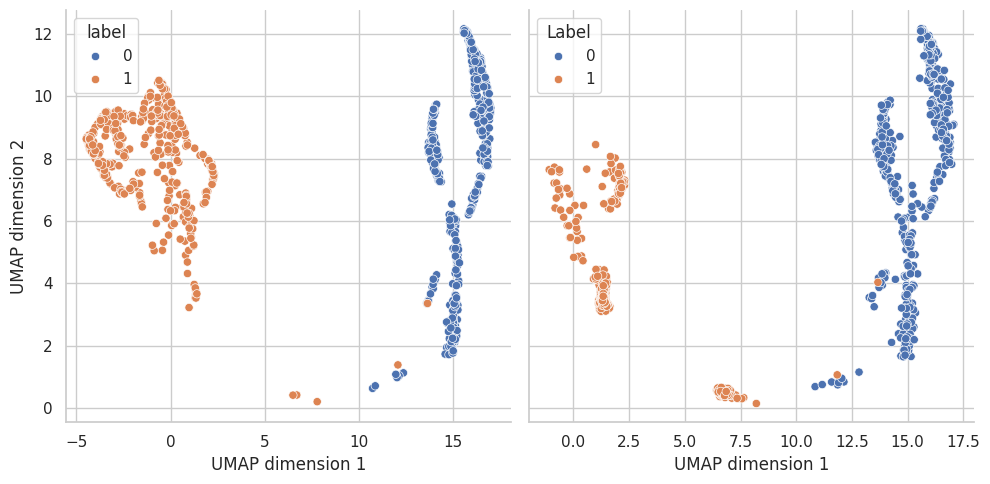

In [29]:
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(10, 5), sharey=True)
sb.scatterplot(data=data[data.prompt_name.isin(TOPICS_ANALYSIS)], x='x_orig', y='y_orig', hue='label', ax = axs[0])
sb.scatterplot(data=data[data.prompt_name.isin(TOPICS_ANALYSIS)], x='x_patch', y='y_patch', hue='label', ax = axs[1])
axs[0].set_xlabel("UMAP dimension 1")
axs[1].set_xlabel("UMAP dimension 1")
axs[0].set_ylabel("UMAP dimension 2")
plt.legend(title='Label')
sb.despine()
plt.tight_layout()
plt.savefig(f"../figs/embedding_trainlabels_original_{DATASET_NAME}_{EXPERIMENT_NAME}_rs_{random_state}.pdf")
plt.savefig(f"../figs/embedding_trainlabels_original_{DATASET_NAME}_{EXPERIMENT_NAME}_rs_{random_state}.png")

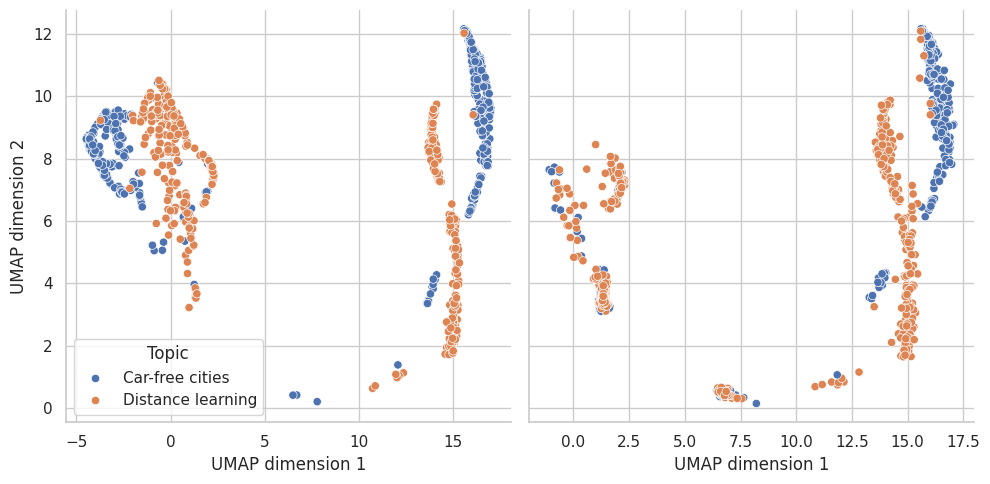

In [28]:
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(10, 5), sharey=True)
sb.scatterplot(data=data[data.prompt_name.isin(TOPICS_ANALYSIS)], x='x_orig', y='y_orig', hue='prompt_name', ax = axs[0], legend=True)
sb.scatterplot(data=data[data.prompt_name.isin(TOPICS_ANALYSIS)], x='x_patch', y='y_patch', hue='prompt_name', ax = axs[1], legend=False)
axs[0].set_xlabel("UMAP dimension 1")
axs[1].set_xlabel("UMAP dimension 1")
axs[0].set_ylabel("UMAP dimension 2")
axs[0].legend(title='Topic')
sb.despine()
plt.tight_layout()
plt.savefig(f"../figs/embedding_traintopics_original_{DATASET_NAME}_{EXPERIMENT_NAME}_rs_{random_state}.pdf")
plt.savefig(f"../figs/embedding_traintopics_original_{DATASET_NAME}_{EXPERIMENT_NAME}_rs_{random_state}.png")

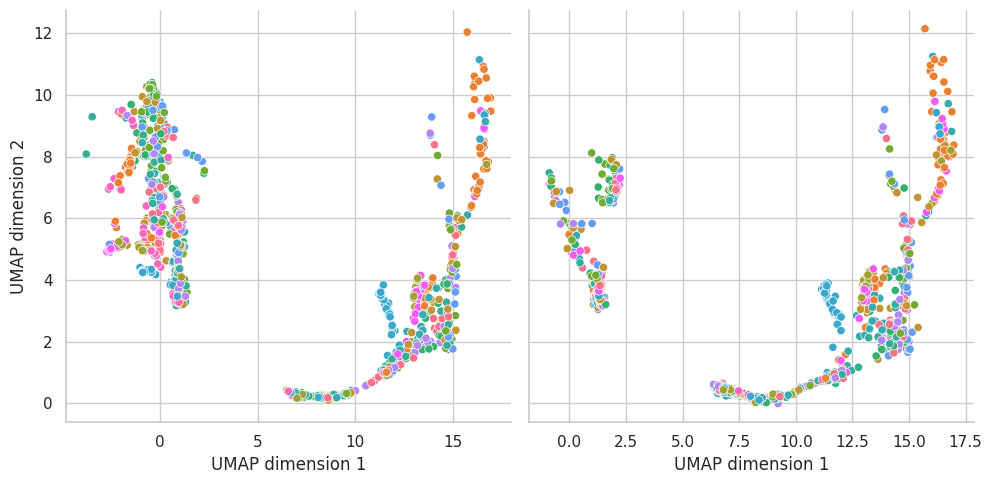

In [30]:
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(10, 5), sharey=True)
sb.scatterplot(data=data[~data.prompt_name.isin(TOPICS_ANALYSIS)], x='x_orig', y='y_orig', hue='prompt_name', ax = axs[0], legend=False)
sb.scatterplot(data=data[~data.prompt_name.isin(TOPICS_ANALYSIS)], x='x_patch', y='y_patch', hue='prompt_name', ax = axs[1], legend=False)
axs[0].set_xlabel("UMAP dimension 1")
axs[1].set_xlabel("UMAP dimension 1")
axs[0].set_ylabel("UMAP dimension 2")
# plt.legend(title='Topic')
sb.despine()
plt.tight_layout()
plt.savefig(f"../figs/embedding_testtopics_original_{DATASET_NAME}_{EXPERIMENT_NAME}_rs_{random_state}.pdf")
plt.savefig(f"../figs/embedding_testtopics_original_{DATASET_NAME}_{EXPERIMENT_NAME}_rs_{random_state}.png")

In [49]:
index_sample = hc3_all.groupby(['source', 'label']).sample(200, random_state=random_state).index.tolist()
hc3_test = hc3_all.loc[index_sample].copy()
hc3_test.label.value_counts()

label
0    1000
1    1000
Name: count, dtype: int64

In [50]:
data = hc3_test.copy()

In [51]:
insp = load_model(f"../models/{MODEL_DICT_ID}", output_hidden_states=True)

In [52]:
embs_original = get_cls_embeddings(data, insp)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:40<00:00, 49.47it/s]


In [53]:
embs_original.shape

(2000, 768)

In [54]:
reducer = umap.UMAP(random_state=random_state, verbose=True)

In [55]:
emb_red_original = reducer.fit_transform(embs_original)

/home/claudio/miniconda3/envs/mechinterp/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/claudio/miniconda3/envs/mechinterp/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP(n_jobs=1, random_state=0, verbose=True)
Fri May  9 09:24:00 2025 Construct fuzzy simplicial set
Fri May  9 09:24:03 2025 Finding Nearest Neighbors
Fri May  9 09:24:03 2025 Finished Nearest Neighbor Search
Fri May  9 09:24:03 2025 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Fri May  9 09:24:06 2025 Finished embedding


In [56]:
data.loc[:, ['x_orig', 'y_orig']] = emb_red_original

In [57]:
patch_suppress_enhance(insp.model, neurons=top_neurons)

In [58]:
embs_patched = get_cls_embeddings(data, insp)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:39<00:00, 51.07it/s]


In [59]:
embs_patched.shape

(2000, 768)

In [60]:
emb_red_patched = reducer.transform(embs_patched)

/home/claudio/miniconda3/envs/mechinterp/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Epochs completed:   0%|            0/100 [00:00]

	completed  0  /  100 epochs
	completed  10  /  100 epochs
	completed  20  /  100 epochs
	completed  30  /  100 epochs
	completed  40  /  100 epochs
	completed  50  /  100 epochs
	completed  60  /  100 epochs
	completed  70  /  100 epochs
	completed  80  /  100 epochs
	completed  90  /  100 epochs


In [61]:
data.loc[:, ['x_patch', 'y_patch']] = emb_red_patched

In [62]:
data.head()

,id,text,source,label,x_orig,y_orig,x_patch,y_patch
19728,19728,"If you're into math, do this thought experimen...",finance,0,-1.957119,4.157468,-1.793504,4.379613
19488,19488,You are not the person or entity against whom ...,finance,0,7.702095,5.422761,5.394238,3.910558
20477,20477,"The strategy is right. As pointed out by you, ...",finance,0,-3.037127,4.498846,-3.393393,4.528918
19816,19816,I would never use a market order. Some broker...,finance,0,1.157444,3.302073,0.452758,3.610050
22709,22709,Adsense don't pay you daily. They pay you ever...,finance,0,0.976264,3.420724,0.702576,3.447394


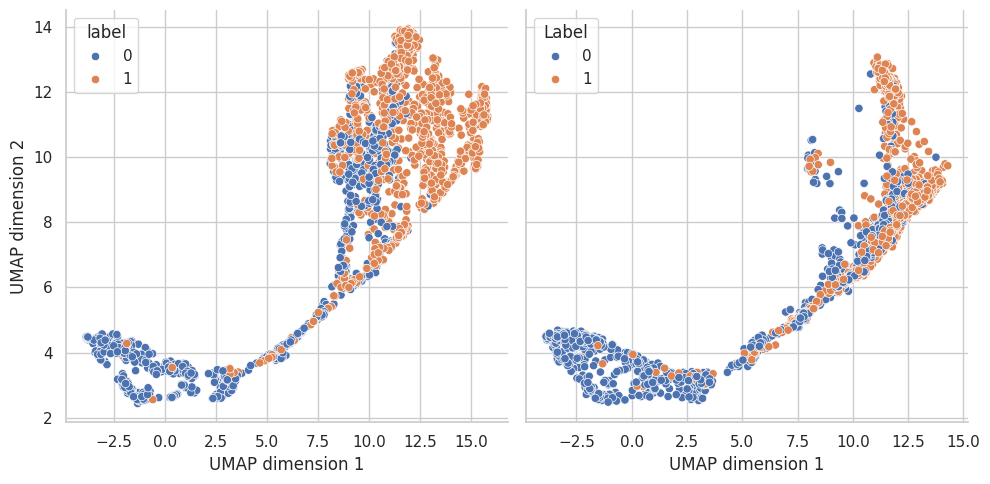

In [63]:
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(10, 5), sharey=True)
sb.scatterplot(data=data, x='x_orig', y='y_orig', hue='label', ax = axs[0])
sb.scatterplot(data=data, x='x_patch', y='y_patch', hue='label', ax = axs[1])
axs[0].set_xlabel("UMAP dimension 1")
axs[1].set_xlabel("UMAP dimension 1")
axs[0].set_ylabel("UMAP dimension 2")
plt.legend(title='Label')
sb.despine()
plt.tight_layout()
plt.savefig(f"../figs/embedding_oodtopics_original_{DATASET_NAME}_{EXPERIMENT_NAME}_rs_{random_state}.pdf")
plt.savefig(f"../figs/embedding_oodtopics_original_{DATASET_NAME}_{EXPERIMENT_NAME}_rs_{random_state}.png")

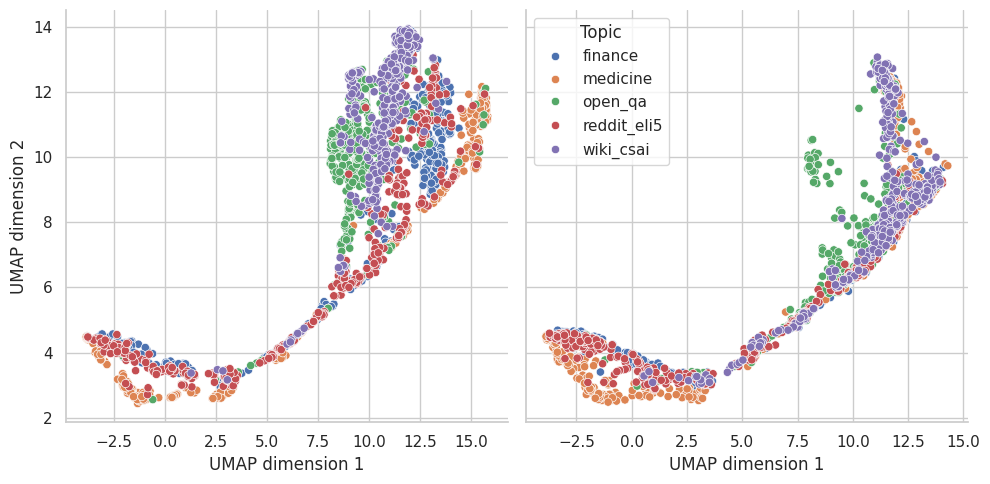

In [67]:
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(10, 5), sharey=True)
sb.scatterplot(data=data, x='x_orig', y='y_orig', hue='source', ax = axs[0], legend=False)
sb.scatterplot(data=data, x='x_patch', y='y_patch', hue='source', ax = axs[1], legend=True)
axs[0].set_xlabel("UMAP dimension 1")
axs[1].set_xlabel("UMAP dimension 1")
axs[0].set_ylabel("UMAP dimension 2")
plt.legend(title='Topic')
sb.despine()
plt.tight_layout()
plt.savefig(f"../figs/embedding_oodtopics_original_{DATASET_NAME}_{EXPERIMENT_NAME}_rs_{random_state}.pdf")
plt.savefig(f"../figs/embedding_oodtopics_original_{DATASET_NAME}_{EXPERIMENT_NAME}_rs_{random_state}.png")